In [1]:
import function_sleepWakeLabels as sleep
import pandas as pd
import numpy as np
from scipy.linalg import solve_triangular
from scipy.stats import pearsonr
import glob
import re
from os.path import join
from datetime import date
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from tqdm.notebook import tqdm

sns.set_theme(style="darkgrid")

In [2]:
dat_dir = '/Users/loranknol/HPC_project/data/'

all_files = sorted(glob.glob("sub-*/preproc/*dat-kp.csv", root_dir=dat_dir, recursive=True))

pat = re.compile(r"sub-(\d+)")
subs = [re.match(pat, f).group(1) for f in all_files]

all_files

['sub-3004/preproc/sub-3004_dat-kp.csv',
 'sub-3006/preproc/sub-3006_dat-kp.csv',
 'sub-3009/preproc/sub-3009_dat-kp.csv',
 'sub-3012/preproc/sub-3012_dat-kp.csv',
 'sub-3014/preproc/sub-3014_dat-kp.csv',
 'sub-3016/preproc/sub-3016_dat-kp.csv',
 'sub-3018/preproc/sub-3018_dat-kp.csv',
 'sub-3022/preproc/sub-3022_dat-kp.csv',
 'sub-3023/preproc/sub-3023_dat-kp.csv',
 'sub-3024/preproc/sub-3024_dat-kp.csv',
 'sub-3025/preproc/sub-3025_dat-kp.csv',
 'sub-3029/preproc/sub-3029_dat-kp.csv',
 'sub-3030/preproc/sub-3030_dat-kp.csv',
 'sub-3032/preproc/sub-3032_dat-kp.csv',
 'sub-3033/preproc/sub-3033_dat-kp.csv',
 'sub-3034/preproc/sub-3034_dat-kp.csv',
 'sub-3037/preproc/sub-3037_dat-kp.csv',
 'sub-3038/preproc/sub-3038_dat-kp.csv',
 'sub-3042/preproc/sub-3042_dat-kp.csv',
 'sub-3043/preproc/sub-3043_dat-kp.csv',
 'sub-3044/preproc/sub-3044_dat-kp.csv',
 'sub-3046/preproc/sub-3046_dat-kp.csv',
 'sub-3047/preproc/sub-3047_dat-kp.csv',
 'sub-3049/preproc/sub-3049_dat-kp.csv',
 'sub-3050/prepr

In [3]:
gsvd_results = {}

for (sub, file) in tqdm(zip(subs, all_files)):
    # read in keypress file
    dfKP = pd.read_csv(join(dat_dir, file), index_col=0)
    dfKP['date'] = pd.to_datetime(dfKP['keypressTimestampLocal']) \
        .map(lambda x: x.date())
    dfKP['dayNumber'] = dfKP['date'].rank(method='dense')

    ################################################################
    # FIND SLEEP/WAKE LABELS FROM BIAFFECT KEYPRESS DATA FILE
    ################################################################
    # STEP 1
    # get input matrices of shape days x hours for typing activity (nKP) and speed (median IKD)
    ## matrices may have missing days
    ## check index here to identify day number since first date of typing data
    Mactivity, Mspeed = sleep.get_typingMatrices(dfKP)

    if Mactivity.empty:
        print("Not enough data, skipping subject {}".format(sub))
        continue

    # STEP 2
    # get graph regularized SVD
    svd = sleep.get_SVD(Mactivity, Mspeed)

    # STEP 3
    # get sleep/wake labels by hour
    sleepMatrix = sleep.get_sleepWakeLabels(svd)

    gsvd_results[sub] = {
        'Mactivity': Mactivity,
        'Mspeed': Mspeed,
        'svd': svd,
        'sleepMatrix': sleepMatrix
    }

0it [00:00, ?it/s]

Not enough data, skipping subject 3004
Not enough data, skipping subject 3006
Not enough data, skipping subject 3012
Not enough data, skipping subject 3014


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
# Plot steps if desired
sleep.plot_heatmaps(Mactivity, Mspeed, svd, sleepMatrix);

In [4]:
self_reports = pd.read_csv(join(dat_dir, "clear3daily_20221205.csv"), index_col=0)
self_reports = self_reports[['id', 'daterated', 'sleepdur_yest', 'SleepLNQuality']]
self_reports = self_reports.dropna()
self_reports['daterated'] = self_reports['daterated'].map(lambda d: date.fromisoformat(d))
self_reports

/var/folders/p7/qsy7v2sd3_j1ypyqv03cpv7r0000gp/T/ipykernel_2565/2381492276.py:1: DtypeWarning: Columns (5,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,126,128,136,137,138,139,140,142,145,150,151,156,158) have mixed types. Specify dtype option on import or set low_memory=False.
  self_reports = pd.read_csv(join(dat_dir, "clear3daily_20221205.csv"), index_col=0)


,id,daterated,sleepdur_yest,SleepLNQuality
1,3001,2020-11-14,2.0,2.0
2,3001,2020-11-15,4.0,2.0
3,3001,2020-11-16,4.0,2.0
4,3001,2020-11-17,5.0,3.0
5,3001,2020-11-18,7.0,3.0
...,...,...,...,...
32749,3118,2022-11-10,5.0,2.0
32750,3118,2022-11-11,4.0,2.0
32751,3118,2022-11-12,4.0,2.0
32753,3118,2022-11-14,5.0,2.0


In [5]:
sr_sub = self_reports.loc[self_reports['id'] == int(subs[2])]
sr_sub

,id,daterated,sleepdur_yest,SleepLNQuality
3228,3009,2021-01-13,6.0,3.0
3229,3009,2021-01-14,5.0,2.0
3230,3009,2021-01-15,5.0,3.0
3231,3009,2021-01-16,5.0,3.0
3232,3009,2021-01-17,5.0,2.0
...,...,...,...,...
3403,3009,2021-07-07,6.0,2.0
3404,3009,2021-07-08,6.0,2.0
3405,3009,2021-07-09,8.0,2.0
3406,3009,2021-07-10,7.0,3.0


In [37]:
dfKP

,healthCode,recordId,createdOnTimestamp,createdOnTimeZone,appVersion,phoneInfo,sessionDuration,timestamp,keypress_type,keypress_duration,...,sessionNumber,sessionTimestampLocal,keypressTimestampLocal,phoneType,IKD,previousKeyType,handedness,date,dayNumber,hour
1,EC7bVNwYAmzxc-9klsv7NUwA,GKckD28sUvSwvLY1xZzHjvR7,1610551018626,-600,"version 2.2.0, build 30","Unknown iPhone [iPhone12,1]; iOS/14.2",9.856795,1.610551e+09,alphanum,0.083155,...,1,2021-01-13 09:16:58,2021-01-13 09:16:58,iPhone 12,NaN,NaN,two-handed,2021-01-13,1.0,9
2,EC7bVNwYAmzxc-9klsv7NUwA,GKckD28sUvSwvLY1xZzHjvR7,1610551018626,-600,"version 2.2.0, build 30","Unknown iPhone [iPhone12,1]; iOS/14.2",9.856795,1.610551e+09,alphanum,0.082185,...,1,2021-01-13 09:16:58,2021-01-13 09:16:58,iPhone 12,0.313727,alphanum,two-handed,2021-01-13,1.0,9
3,EC7bVNwYAmzxc-9klsv7NUwA,GKckD28sUvSwvLY1xZzHjvR7,1610551018626,-600,"version 2.2.0, build 30","Unknown iPhone [iPhone12,1]; iOS/14.2",9.856795,1.610551e+09,alphanum,0.082252,...,1,2021-01-13 09:16:58,2021-01-13 09:16:59,iPhone 12,0.175755,alphanum,two-handed,2021-01-13,1.0,9
4,EC7bVNwYAmzxc-9klsv7NUwA,GKckD28sUvSwvLY1xZzHjvR7,1610551018626,-600,"version 2.2.0, build 30","Unknown iPhone [iPhone12,1]; iOS/14.2",9.856795,1.610551e+09,alphanum,0.074835,...,1,2021-01-13 09:16:58,2021-01-13 09:16:59,iPhone 12,0.458351,alphanum,two-handed,2021-01-13,1.0,9
5,EC7bVNwYAmzxc-9klsv7NUwA,GKckD28sUvSwvLY1xZzHjvR7,1610551018626,-600,"version 2.2.0, build 30","Unknown iPhone [iPhone12,1]; iOS/14.2",9.856795,1.610551e+09,alphanum,0.091569,...,1,2021-01-13 09:16:58,2021-01-13 09:16:59,iPhone 12,0.166526,alphanum,two-handed,2021-01-13,1.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223288,EC7bVNwYAmzxc-9klsv7NUwA,mzVPNe2qQ6Ay-3DS2X9UbjIR,1626189777794,-500,"version 2.2.0, build 30","Unknown iPhone [iPhone12,1]; iOS/14.6",14.997075,1.626190e+09,alphanum,0.108232,...,8197,2021-07-13 10:22:57,2021-07-13 10:23:04,iPhone 12,0.165735,alphanum,two-handed,2021-07-13,182.0,10
223289,EC7bVNwYAmzxc-9klsv7NUwA,mzVPNe2qQ6Ay-3DS2X9UbjIR,1626189777794,-500,"version 2.2.0, build 30","Unknown iPhone [iPhone12,1]; iOS/14.6",14.997075,1.626190e+09,alphanum,0.099732,...,8197,2021-07-13 10:22:57,2021-07-13 10:23:04,iPhone 12,0.216877,alphanum,two-handed,2021-07-13,182.0,10
223290,EC7bVNwYAmzxc-9klsv7NUwA,mzVPNe2qQ6Ay-3DS2X9UbjIR,1626189777794,-500,"version 2.2.0, build 30","Unknown iPhone [iPhone12,1]; iOS/14.6",14.997075,1.626190e+09,alphanum,0.090719,...,8197,2021-07-13 10:22:57,2021-07-13 10:23:04,iPhone 12,0.273869,alphanum,two-handed,2021-07-13,182.0,10
223291,EC7bVNwYAmzxc-9klsv7NUwA,mzVPNe2qQ6Ay-3DS2X9UbjIR,1626189777794,-500,"version 2.2.0, build 30","Unknown iPhone [iPhone12,1]; iOS/14.6",14.997075,1.626190e+09,alphanum,0.058250,...,8197,2021-07-13 10:22:57,2021-07-13 10:23:05,iPhone 12,0.367627,alphanum,two-handed,2021-07-13,182.0,10


In [6]:
merged = dfKP.merge(sr_sub, how='outer', left_on='date', right_on='daterated')
merged

,healthCode,recordId,createdOnTimestamp,createdOnTimeZone,appVersion,phoneInfo,sessionDuration,timestamp,keypress_type,keypress_duration,...,IKD,previousKeyType,handedness,date,dayNumber,hour,id,daterated,sleepdur_yest,SleepLNQuality
0,EC7bVNwYAmzxc-9klsv7NUwA,GKckD28sUvSwvLY1xZzHjvR7,1610551018626,-600,"version 2.2.0, build 30","Unknown iPhone [iPhone12,1]; iOS/14.2",9.856795,1.610551e+09,alphanum,0.083155,...,NaN,NaN,two-handed,2021-01-13,1.0,9,3009.0,2021-01-13,6.0,3.0
1,EC7bVNwYAmzxc-9klsv7NUwA,GKckD28sUvSwvLY1xZzHjvR7,1610551018626,-600,"version 2.2.0, build 30","Unknown iPhone [iPhone12,1]; iOS/14.2",9.856795,1.610551e+09,alphanum,0.082185,...,0.313727,alphanum,two-handed,2021-01-13,1.0,9,3009.0,2021-01-13,6.0,3.0
2,EC7bVNwYAmzxc-9klsv7NUwA,GKckD28sUvSwvLY1xZzHjvR7,1610551018626,-600,"version 2.2.0, build 30","Unknown iPhone [iPhone12,1]; iOS/14.2",9.856795,1.610551e+09,alphanum,0.082252,...,0.175755,alphanum,two-handed,2021-01-13,1.0,9,3009.0,2021-01-13,6.0,3.0
3,EC7bVNwYAmzxc-9klsv7NUwA,GKckD28sUvSwvLY1xZzHjvR7,1610551018626,-600,"version 2.2.0, build 30","Unknown iPhone [iPhone12,1]; iOS/14.2",9.856795,1.610551e+09,alphanum,0.074835,...,0.458351,alphanum,two-handed,2021-01-13,1.0,9,3009.0,2021-01-13,6.0,3.0
4,EC7bVNwYAmzxc-9klsv7NUwA,GKckD28sUvSwvLY1xZzHjvR7,1610551018626,-600,"version 2.2.0, build 30","Unknown iPhone [iPhone12,1]; iOS/14.2",9.856795,1.610551e+09,alphanum,0.091569,...,0.166526,alphanum,two-handed,2021-01-13,1.0,9,3009.0,2021-01-13,6.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223287,EC7bVNwYAmzxc-9klsv7NUwA,mzVPNe2qQ6Ay-3DS2X9UbjIR,1626189777794,-500,"version 2.2.0, build 30","Unknown iPhone [iPhone12,1]; iOS/14.6",14.997075,1.626190e+09,alphanum,0.108232,...,0.165735,alphanum,two-handed,2021-07-13,182.0,10,NaN,NaN,NaN,NaN
223288,EC7bVNwYAmzxc-9klsv7NUwA,mzVPNe2qQ6Ay-3DS2X9UbjIR,1626189777794,-500,"version 2.2.0, build 30","Unknown iPhone [iPhone12,1]; iOS/14.6",14.997075,1.626190e+09,alphanum,0.099732,...,0.216877,alphanum,two-handed,2021-07-13,182.0,10,NaN,NaN,NaN,NaN
223289,EC7bVNwYAmzxc-9klsv7NUwA,mzVPNe2qQ6Ay-3DS2X9UbjIR,1626189777794,-500,"version 2.2.0, build 30","Unknown iPhone [iPhone12,1]; iOS/14.6",14.997075,1.626190e+09,alphanum,0.090719,...,0.273869,alphanum,two-handed,2021-07-13,182.0,10,NaN,NaN,NaN,NaN
223290,EC7bVNwYAmzxc-9klsv7NUwA,mzVPNe2qQ6Ay-3DS2X9UbjIR,1626189777794,-500,"version 2.2.0, build 30","Unknown iPhone [iPhone12,1]; iOS/14.6",14.997075,1.626190e+09,alphanum,0.058250,...,0.367627,alphanum,two-handed,2021-07-13,182.0,10,NaN,NaN,NaN,NaN


In [7]:
sleep_scores = merged[['dayNumber', 'sleepdur_yest', 'SleepLNQuality']].drop_duplicates()
sleep_scores

,dayNumber,sleepdur_yest,SleepLNQuality
0,1.0,6.0,3.0
492,2.0,5.0,2.0
2014,3.0,5.0,3.0
2811,4.0,5.0,3.0
3397,5.0,5.0,2.0
...,...,...,...
220402,178.0,8.0,2.0
220608,179.0,7.0,3.0
221456,180.0,6.0,2.0
222163,181.0,NaN,NaN


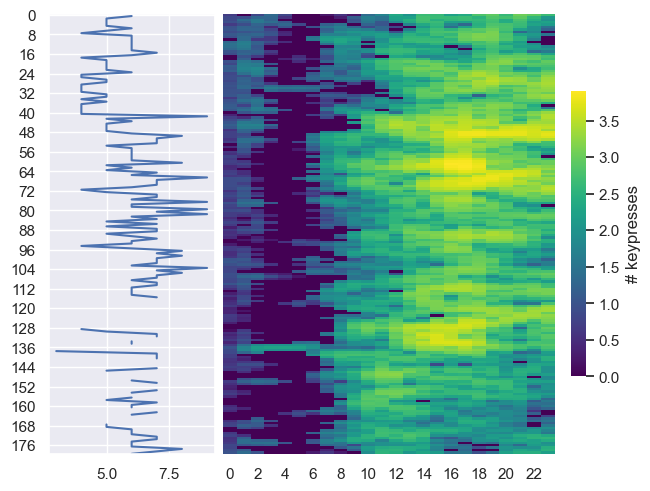

In [25]:
fig = plt.figure(layout="constrained")
gs = GridSpec(1, 3, fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1:], sharey=ax1)

ax1.plot(sleep_scores['sleepdur_yest'], sleep_scores['dayNumber'])
ax1.invert_yaxis()
# sns.lineplot(sleep_scores, x='dayNumber', y='value', hue='variable', ax=ax2)
hm = sns.heatmap(svd, cmap='viridis', ax=ax2,
                 cbar_kws={'label': '# keypresses', 'fraction': 0.043})
plt.setp(ax2.get_yticklabels(), visible=False);

In [21]:
days = Mactivity.index
sleep_pred = np.sum(1 - sleepMatrix, axis=1)
sleep_pred = pd.DataFrame({'dayNumber': days.values, 'sleep_pred': sleep_pred})

sleep_scores = sleep_scores.merge(sleep_pred, how='outer', on='dayNumber')
sleep_scores

,dayNumber,sleepdur_yest,SleepLNQuality,sleep_pred
0,1.0,6.0,3.0,NaN
1,2.0,5.0,2.0,2.0
2,3.0,5.0,3.0,3.0
3,4.0,5.0,3.0,5.0
4,5.0,5.0,2.0,4.0
...,...,...,...,...
177,178.0,8.0,2.0,3.0
178,179.0,7.0,3.0,7.0
179,180.0,6.0,2.0,7.0
180,181.0,NaN,NaN,7.0


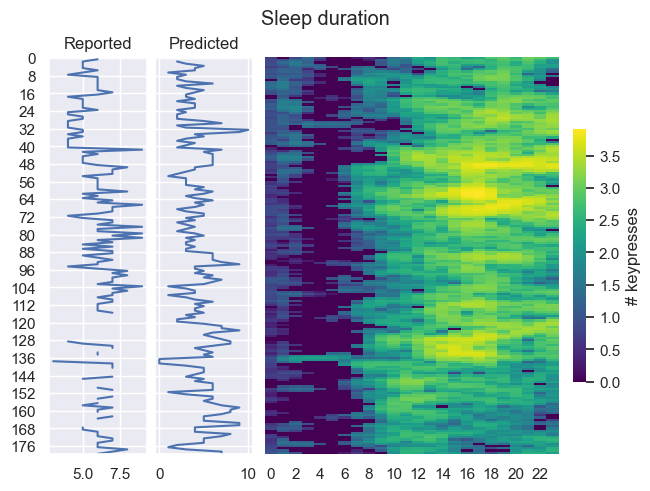

In [39]:
fig = plt.figure(layout="constrained")

fig.suptitle("Sleep duration")

gs = GridSpec(1, 5, fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
ax3 = fig.add_subplot(gs[0, 2:], sharey=ax1)

ax1.plot(sleep_scores['sleepdur_yest'], sleep_scores['dayNumber'])
ax1.invert_yaxis()
ax1.set_title('Reported')

ax2.plot(sleep_scores['sleep_pred'], sleep_scores['dayNumber'])
ax2.set_title('Predicted')
plt.setp(ax2.get_yticklabels(), visible=False);

sns.heatmap(svd, cmap='viridis', ax=ax3,
            cbar_kws={'label': '# keypresses', 'fraction': 0.043})
plt.setp(ax3.get_yticklabels(), visible=False);

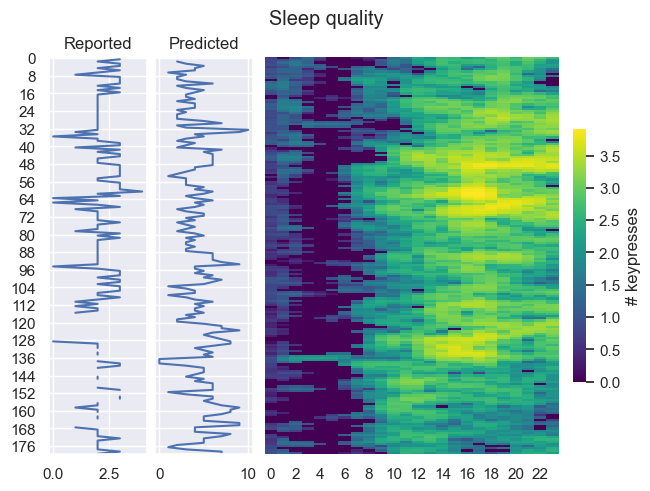

In [40]:
fig = plt.figure(layout="constrained")

fig.suptitle("Sleep quality")

gs = GridSpec(1, 5, fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
ax3 = fig.add_subplot(gs[0, 2:], sharey=ax1)

ax1.plot(sleep_scores['SleepLNQuality'], sleep_scores['dayNumber'])
ax1.invert_yaxis()
ax1.set_title('Reported')

ax2.plot(sleep_scores['sleep_pred'], sleep_scores['dayNumber'])
ax2.set_title('Predicted')
plt.setp(ax2.get_yticklabels(), visible=False);

sns.heatmap(svd, cmap='viridis', ax=ax3,
            cbar_kws={'label': '# keypresses', 'fraction': 0.043})
plt.setp(ax3.get_yticklabels(), visible=False);

PearsonRResult(statistic=0.09495065756954787, pvalue=0.23837374143353948)


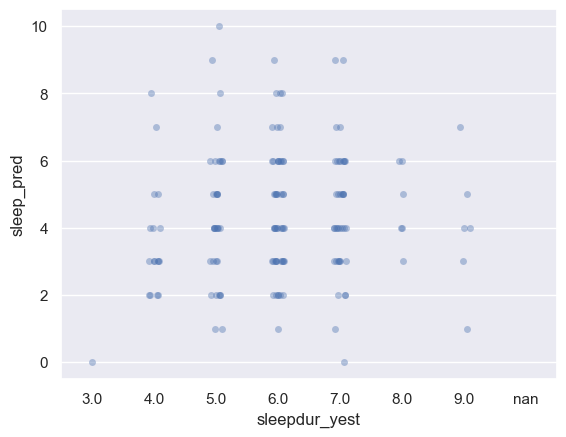

In [38]:
sns.stripplot(sleep_scores, x="sleepdur_yest", y="sleep_pred", alpha=0.4)

ss_complete = sleep_scores.dropna()
print(pearsonr(ss_complete['sleepdur_yest'], ss_complete['sleep_pred']))

PearsonRResult(statistic=-0.10565219497939611, pvalue=0.18929765221763328)


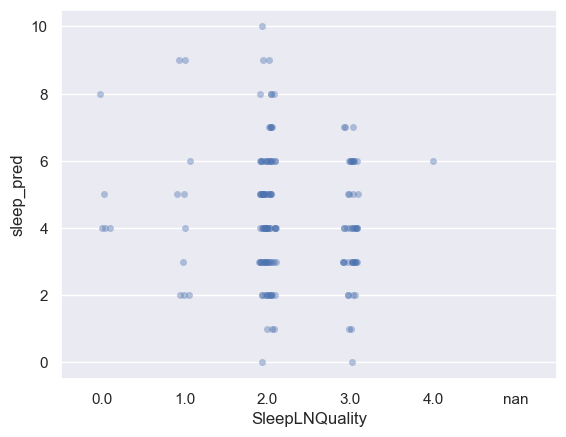

In [42]:
sns.stripplot(sleep_scores, x="SleepLNQuality", y="sleep_pred", alpha=0.4)
print(pearsonr(ss_complete['SleepLNQuality'], ss_complete['sleep_pred']))